In [5]:
from Bio.PDB import PDBParser
import time
import scipy
import time
import scipy.spatial
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt



In [53]:
'''Supplementary functions'''

def extract_pdb_info(pdb_file_path):
    """
    Reads a PDB file and extracts 3D spatial coordinates and amino acids.

    Input: pdb_file_path (str): Path to the PDB file.

    Output:  A list of dictionaries, each containing information about each atom.
    """
    # Create a PDBParser object
    parser = PDBParser(PERMISSIVE=1)
    
    # Parse the structure from the PDB file
    structure = parser.get_structure('protein', pdb_file_path)
    
    # List to hold the extracted information
    atom_info_list = []

    # Extract information from the structure
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    atom_info = {
                        'model_id': model.id,
                        'chain_id': chain.id,
                        'residue_name': residue.resname,
                        'residue_id': residue.id[1],
                        'atom_name': atom.name,
                        'atom_coords': atom.coord.tolist()
                    }
                    atom_info_list.append(atom_info)

    return atom_info_list

def find_nearest_neighbors(data, angstrom):
    """
    Find the n-neighbors closest to the 'CA' atoms in the data using brute force with Euclidean distance.

    Parameters:
    - data: list of dictionaries, each containing atom information
    - angstrom: float, distance threshold for neighbor counting

    Returns:
    - data: list of dictionaries, containing only 'CA' atoms with updated 'neighbour_count' field,
      and without 'model_id', 'atom_name', and 'atom_coords' keys.
    """
    start_time = time.time()

    # Filter data to only include 'CA' atoms in chain_id 'A'
    ca_atoms = [atom for atom in data if atom.get('chain_id') == 'A' and atom['atom_name'] == 'CA']
    ca_coords = np.array([atom['atom_coords'] for atom in ca_atoms])

    # Calculate distances between 'CA' atoms
    distances = scipy.spatial.distance.cdist(ca_coords, ca_coords, 'euclidean')

    # Use 'residue_id' for DataFrame indexing
    residue_ids = [atom.get('residue_id', f"residue_{i}") for i, atom in enumerate(ca_atoms)]
    
    # Convert distance matrix to pandas DataFrame
    distance_df = pd.DataFrame(distances, index=residue_ids, columns=residue_ids)

    # Format distance matrix to 3 decimal places
    distance_df = distance_df.round(3)

    # Print the distance matrix
    print("Distance matrix between CA atoms (formatted to 3 decimal places):")
    print(distance_df)

    # Count neighbors within a distance of 'angstrom' units for each 'CA' atom
    for index, ca_point in enumerate(ca_coords):
        neighbour_count = np.sum((distances[index] <= angstrom) & (distances[index] != 0))
        ca_atoms[index]['neighbour_count'] = neighbour_count

    # Remove specified keys from the 'CA' atoms
    keys_to_remove = ['model_id', 'atom_name', 'atom_coords']
    for atom in ca_atoms:
        for key in keys_to_remove:
            atom.pop(key, None)

    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Elapsed time: {elapsed:.2f} seconds")

    return ca_atoms

def extract_conservation_score(filename):
    result = []
    try:
        with open(filename, 'r') as file:
            for line in file:
                # Skip header lines and lines below confidence cut-off
                if re.match(r'\s*\d+', line):
                    columns = line.split()
                    pos = int(columns[0])
                    score = float(columns[3])

                    # Check if there is a 3LATOM value, otherwise continue
                    if len(columns) > 6 and ':' in columns[2]:
                        residue_id = re.findall(r'\d+', columns[2])[0]  # Extract numbers from the string
                        residue_id = int(residue_id)  # Convert extracted string to integer
                        residue_name = re.findall(r'[A-Za-z]+', columns[2])[0]  # Extract letters from the string
                        result.append({'residue_id': residue_id, 'residue_name': residue_name, 'conservation_score': score})

        return result
    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        return None

def merge_residue_data(conservation_scores, neighbour_counts):
    # Create a dictionary to index the neighbour_counts by residue_id and residue_name
    neighbour_dict = {(item['residue_id'], item['residue_name']): item for item in neighbour_counts}
    
    # List to hold merged data
    merged_data = []
    
    # Merge data from conservation_scores with neighbour_counts
    for score_entry in conservation_scores:
        residue_id = score_entry['residue_id']
        residue_name = score_entry['residue_name']
        
        # Find the corresponding entry in neighbour_counts
        neighbour_entry = neighbour_dict.get((residue_id, residue_name))
        
        if neighbour_entry:
            # Merge the two entries
            merged_entry = {
                'residue_id': residue_id,
                'residue_name': residue_name,
                'conservation_score': score_entry['conservation_score'],
                'neighbour_count': neighbour_entry['neighbour_count']
            }
            merged_data.append(merged_entry)
    
    return merged_data

def plot_and_calculate_correlation(data, title, num_residues=1600):
    # Extract data for plotting
    residue_ids = [entry['residue_id'] for entry in data]
    neighbour_counts = [entry['neighbour_count'] for entry in data]
    
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    
    # Plot neighbour counts
    plt.scatter(residue_ids, neighbour_counts, color='green', label='Neighbour Count')
    
    # Check and plot conservation scores if available
    conservation_scores = [entry['conservation_score'] for entry in data if 'conservation_score' in entry and entry['conservation_score'] is not None]
    if conservation_scores:
        valid_entries = [entry for entry in data if 'conservation_score' in entry and entry['conservation_score'] is not None]
        valid_residue_ids = [entry['residue_id'] for entry in valid_entries]
        valid_neighbour_counts = [entry['neighbour_count'] for entry in valid_entries]
        
        plt.scatter(valid_residue_ids, conservation_scores, color='blue', label='Conservation Score')
        
        # Calculate and print the correlation
        if len(valid_residue_ids) == len(conservation_scores):
            correlation = np.corrcoef(conservation_scores, valid_neighbour_counts)[0, 1]
            print(f"Correlation between Conservation Score and Neighbour Count: {correlation}")
        else:
            print("Mismatch in lengths of valid_residue_ids and conservation_scores")
    else:
        print("Conservation scores not found. Plotting only Neighbour Count.")
    
    plt.xlabel('Residue ID')
    plt.ylabel('Score / Count')
    plt.title(f'{title}: Residue ID vs Conservation Score and Neighbour Count ({angstrom}A)')
    plt.legend()
    
    # Set plot limits for residue IDs
    plt.xlim(0, num_residues)
    
    # Display the plot
    plt.tight_layout()
    plt.show()


In [47]:
import asyncio
import os
import re
from playwright.async_api import async_playwright

def download_conservation_scores(pdb_file_path, chains):
    pattern = r'pdb(\w+)\.pdb'
    pdb_ids = [match.group(1).upper() for file_path in pdb_file_path if (match := re.search(pattern, file_path))]
    print(pdb_ids)
    
    # Ensure the directory for saving files exists
    output_dir = "conservation_scores"
    os.makedirs(output_dir, exist_ok=True)

    async def scrape_consurf(pdb_id, chain):
        url = f"https://consurfdb.tau.ac.il/DB/{pdb_id.upper()}{chain}/{pdb_id.upper()}{chain}_consurf_summary.txt"
        async with async_playwright() as p:
            browser = await p.chromium.launch()
            page = await browser.new_page()
            try:
                await page.goto(url, timeout=60000)  # Increase timeout to 60 seconds
                content = await page.content()  # Get the content of the page
                if "Page not found" in content:
                    print(f"Error: Page not found for {pdb_id} chain {chain}")
                    return None
                else:
                    content = await page.text_content("body")  # Get the text content directly from the body
                    if content and "Page not found" not in content:
                        file_path = f"{output_dir}/{pdb_id}_consurf_summary.txt"
                        with open(file_path, "w") as file:
                            file.write(content)
                        print(f"Summary for {pdb_id} chain {chain} saved successfully at {file_path}.")
                        return content
                    else:
                        print(f"Content for {pdb_id} chain {chain} not found or invalid.")
                        return None
            except Exception as e:
                print(f"Error processing {pdb_id} chain {chain}: {e}")
                return None
            finally:
                await browser.close()

    async def main():
        tasks = []
        for pdb_id in pdb_ids:
            for chain in chains:
                tasks.append(scrape_consurf(pdb_id, chain))
        
        # Run all tasks concurrently and gather their results
        results = await asyncio.gather(*tasks, return_exceptions=True)
        
        for pdb_id, result in zip(pdb_ids, results):
            if isinstance(result, Exception):
                print(f"Error processing {pdb_id}: {result}")
            elif result:
                print(f"Summary for {pdb_id} saved successfully.")
            else:
                print(f"No content saved for {pdb_id}.")

    # Helper function to run the asyncio code in the correct context
    def run_async_code():
        try:
            loop = asyncio.get_running_loop()
            if loop.is_running():
                return loop.create_task(main())
        except RuntimeError:
            return asyncio.run(main())

    run_async_code()

In [49]:
'''Main function'''

def pdb_to_n_neighbour_vector(pdb_file_path, angstrom):
    # convert_cif_to_pdb(cif_file_path, pdb_file_path)
    amino_vector = []
    title = pdb_file_path.split('/')[-1].split('.')[0][3:].upper()

    atom_info_list = extract_pdb_info(pdb_file_path)

    amino_acid_info_count = find_nearest_neighbors(atom_info_list, angstrom)

    print(f"Number of Amino Acids: {len(amino_acid_info_count)}")
    conservation_scores = extract_conservation_score(filename=f"conservation_scores/{title}_consurf_summary.txt")
    print(conservation_scores)

    if conservation_scores is not None:
        merged_residues = merge_residue_data(conservation_scores, amino_acid_info_count)
        print(merged_residues)
        plot_and_calculate_correlation(merged_residues, title, angstrom)
    else:
        print("Conservation scores not found, skipping merge_residue_data. Going straight to plotting.")
        merged_residues = amino_acid_info_count
        plot_and_calculate_correlation(merged_residues, title, angstrom)

    return merged_residues

def merge_to_ref_seq(ref_seq, completed):
    # Convert ref_seq to dictionary for efficient lookup
    ref_seq_dict = {entry['residue_id']: entry for entry in ref_seq}

    for entry in completed:
        residue_id = entry['residue_id']
        if residue_id in ref_seq_dict:
            ref_seq_entry = ref_seq_dict[residue_id]
            if 'neighbour_count' in entry:
                ref_seq_entry['neighbour_count'] = entry['neighbour_count']
            if 'conservation_score' in entry:
                ref_seq_entry['conservation_score'] = entry['conservation_score']
        else:
            ref_seq_dict[residue_id] = {
                'residue_id': residue_id,
                'residue_name': entry['residue_name'],
                'neighbour_count': entry.get('neighbour_count', 0),
                'conservation_score': entry.get('conservation_score')
            }

    # Convert back to list
    updated_ref_seq = list(ref_seq_dict.values())
    return updated_ref_seq



In [50]:
pdb_file_path = ['./pdb/pdb4i5i.pdb', './pdb/pdb4if6.pdb', './pdb/pdb4ig9.pdb', './pdb/pdb4kxq.pdb', './pdb/pdb4zzh.pdb']
                 
# './pdb/pdb8v9u.pdb' excluded
download_conservation_scores(pdb_file_path, chains = ['A'])

['4I5I', '4IF6', '4IG9', '4KXQ', '4ZZH']


Distance matrix between CA atoms (formatted to 3 decimal places):
        1       2       3       4       5       6       7       8       9    \
1     0.000   3.064   6.419   9.419  12.796  15.785  19.646  22.403  26.023   
2     3.064   0.000   3.857   6.970  10.014  13.267  17.134  19.943  23.486   
3     6.419   3.857   0.000   3.388   6.538   9.635  13.478  16.459  20.031   
4     9.419   6.970   3.388   0.000   3.808   6.373  10.235  13.122  16.736   
5    12.796  10.014   6.538   3.808   0.000   3.841   7.446  10.412  13.779   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
743  45.392  43.906  40.267  37.741  36.493  33.171  30.454  29.906  29.109   
744  46.307  44.680  40.978  38.245  36.754  33.257  30.251  29.265  28.044   
745  49.115  47.356  43.602  40.776  39.040  35.497  32.278  31.041  29.424   
746  49.959  48.098  44.333  41.353  39.437  35.791  32.382  30.755  28.778   
747  49.897  47.881  44.096  41.017  38.845  35.186  31.602  29.7

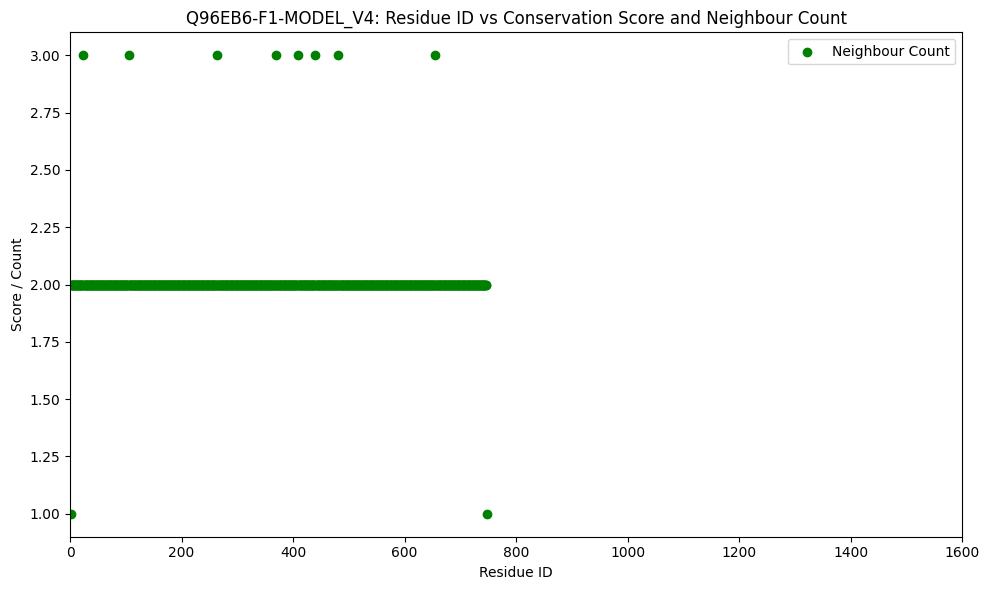

Distance matrix between CA atoms (formatted to 3 decimal places):
        241     242     243     244     245     246     247     248     249  \
241   0.000   3.829   7.038   8.290   6.348   7.742  10.934  11.201  11.021   
242   3.829   0.000   3.818   5.268   5.200   6.647   8.943   9.976  10.859   
243   7.038   3.818   0.000   3.832   5.366   5.026   6.400   8.743   9.870   
244   8.290   5.268   3.832   0.000   3.822   5.408   5.111   6.253   8.677   
245   6.348   5.200   5.366   3.822   0.000   3.816   5.377   4.987   6.140   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
508  32.007  29.818  27.070  29.935  31.962  29.252  29.258  33.078  33.146   
509  33.953  32.085  29.499  32.563  34.301  31.443  31.749  35.540  35.276   
510  33.800  32.243  29.664  32.803  34.171  31.062  31.546  35.266  34.608   
511  37.357  35.915  33.351  36.489  37.760  34.567  35.064  38.752  37.952   
512  38.585  37.479  35.065  38.298  39.235  35.926  36.675  40.2

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4831.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4894.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4957.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5044.
  warnings.warn(


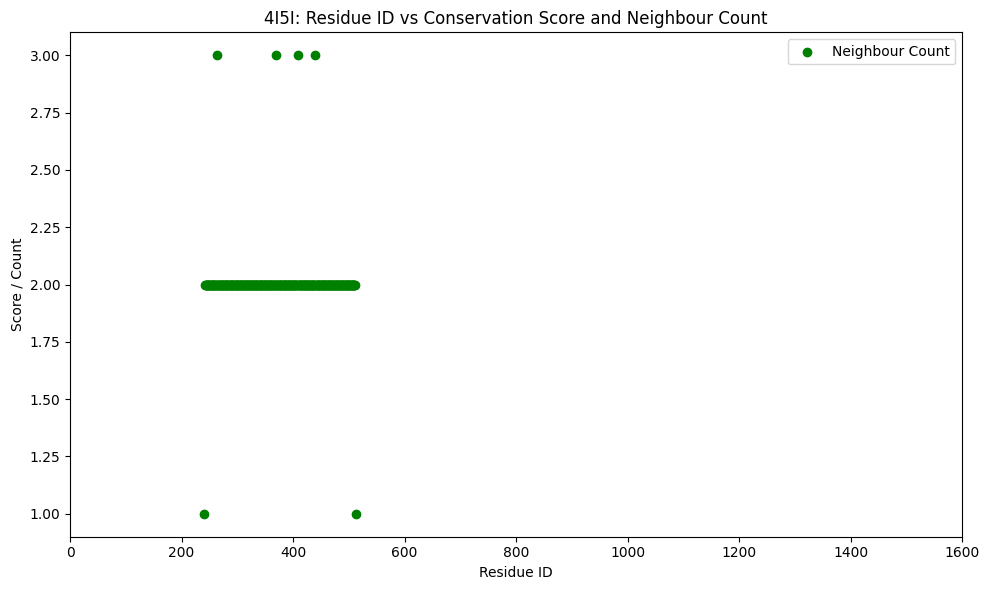

Distance matrix between CA atoms (formatted to 3 decimal places):
        -1       234     235     236     237     238     239     240     241  \
-1     0.000   3.804   6.532   9.950  12.607  15.487  18.184  17.743  18.962   
 234   3.804   0.000   3.794   6.669   9.038  12.216  14.623  14.043  15.501   
 235   6.532   3.794   0.000   3.793   6.494   9.001  11.951  11.842  13.018   
 236   9.950   6.669   3.793   0.000   3.779   6.174   8.929   8.309   9.229   
 237  12.607   9.038   6.494   3.779   0.000   3.784   5.598   5.793   8.013   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
 506  44.482  41.339  40.779  37.458  36.591  36.807  34.555  31.471  30.163   
 507  47.334  44.073  43.359  39.945  38.820  38.815  36.343  33.488  32.262   
 508  48.930  45.660  45.160  41.843  40.590  40.797  38.173  35.340  34.453   
 509  52.372  49.091  48.656  45.365  44.015  44.244  41.514  38.762  38.007   
 510  54.136  50.980  50.757  47.574  46.407  46.842  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5632.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5882.
  warnings.warn(


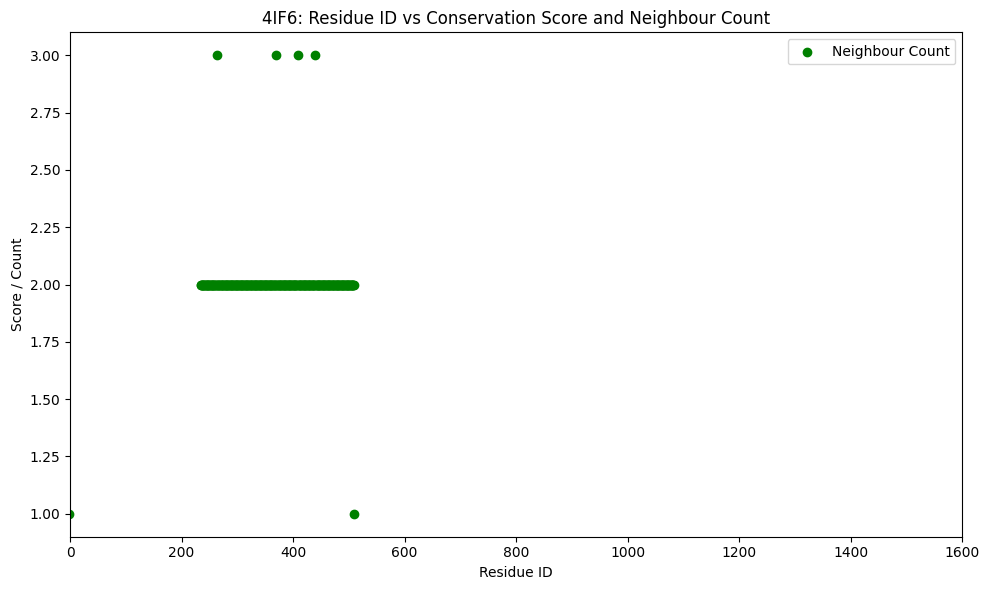

Distance matrix between CA atoms (formatted to 3 decimal places):
        -1       234     235     236     237     238     239     240     241  \
-1     0.000   3.812   6.578   9.879  12.553  15.466  18.108  17.788  19.062   
 234   3.812   0.000   3.797   6.546   8.951  12.147  14.520  14.047  15.524   
 235   6.578   3.797   0.000   3.808   6.408   8.925  11.835  11.926  13.199   
 236   9.879   6.546   3.808   0.000   3.803   6.197   8.970   8.486   9.417   
 237  12.553   8.951   6.408   3.803   0.000   3.804   5.585   5.849   8.055   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
 497  34.021  30.839  31.055  28.104  26.945  28.076  25.807  22.498  22.296   
 498  36.359  33.102  32.986  29.795  28.619  29.313  27.009  23.758  23.081   
 499  38.963  35.848  36.001  32.944  31.913  32.811  30.572  27.259  26.641   
 500  36.718  33.796  34.172  31.248  30.614  31.766  29.890  26.361  25.604   
 501  37.348  34.407  34.478  31.355  30.860  31.660  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10152.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10153.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 10154.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 10155.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10156.
  warni

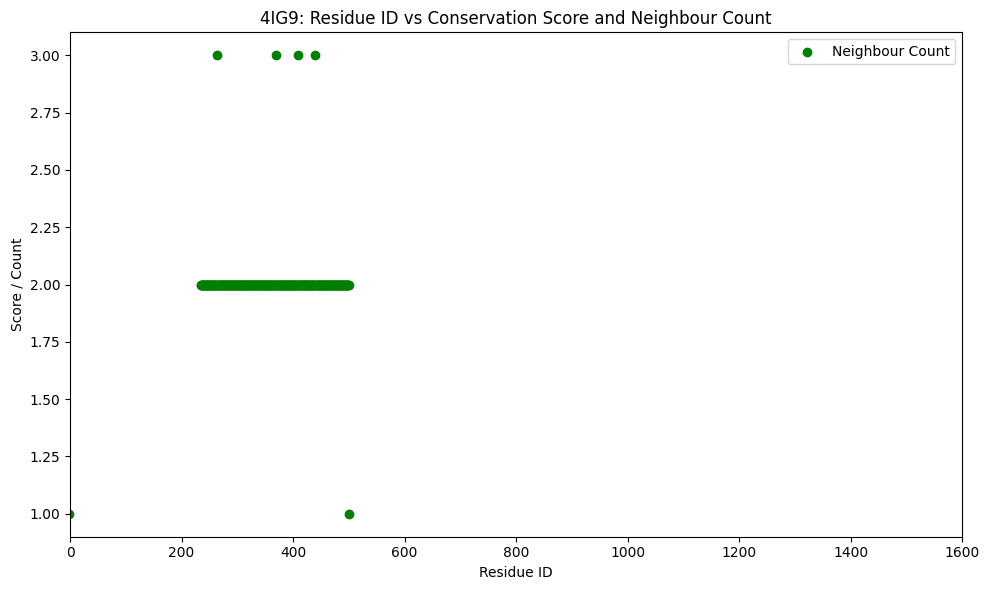

Distance matrix between CA atoms (formatted to 3 decimal places):
        232     233     234     235     236     237     238     239     240  \
232   0.000   3.804   6.751   8.940  12.688  14.889  17.518  20.131  20.283   
233   3.804   0.000   3.781   6.433   9.927  12.659  15.489  18.100  17.702   
234   6.751   3.781   0.000   3.811   6.732   9.186  12.349  14.634  14.053   
235   8.940   6.433   3.811   0.000   3.806   6.590   9.098  11.938  11.840   
236  12.688   9.927   6.732   3.806   0.000   3.788   6.228   8.860   8.289   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
506  48.003  44.583  41.378  40.832  37.554  36.627  36.985  34.664  31.563   
507  50.753  47.401  44.086  43.386  40.008  38.817  38.955  36.421  33.547   
508  52.277  49.019  45.689  45.205  41.928  40.619  40.964  38.279  35.422   
509  55.660  52.457  49.114  48.699  45.450  44.047  44.415  41.627  38.848   
510  57.370  54.135  50.907  50.709  47.577  46.363  46.942  44.2

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5452.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5800.
  warnings.warn(


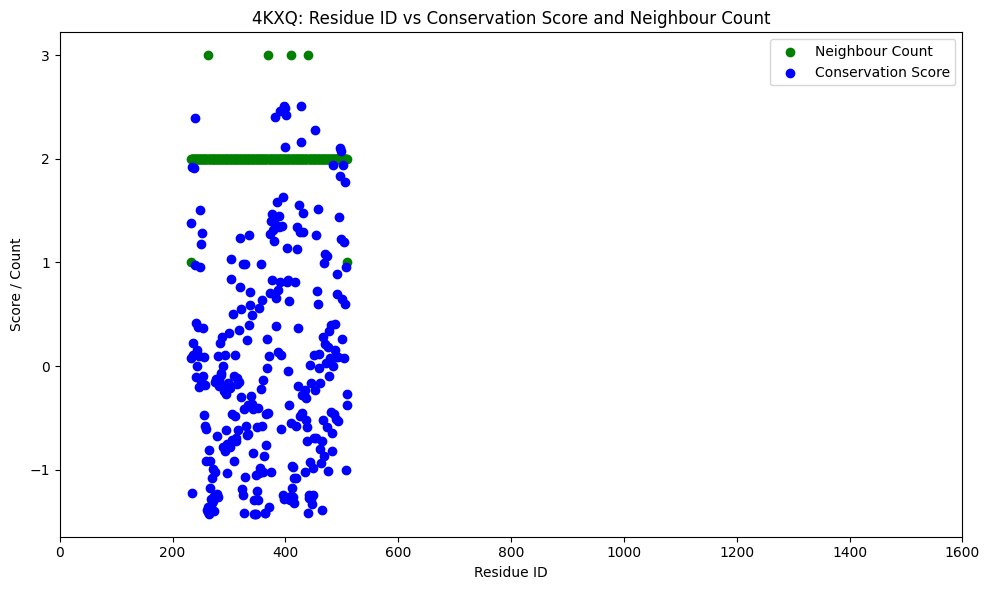

Distance matrix between CA atoms (formatted to 3 decimal places):
        183     184     185     186     187     188     189     190     191  \
183   0.000   3.831   5.110   5.294   6.450   8.916   9.903  10.915  12.874   
184   3.831   0.000   3.809   5.471   4.860   6.381   8.686   9.913  10.770   
185   5.110   3.809   0.000   3.800   5.361   5.335   6.346   8.824  10.075   
186   5.294   5.471   3.800   0.000   3.797   5.348   4.827   6.176   8.643   
187   6.450   4.860   5.361   3.797   0.000   3.807   5.477   5.290   6.555   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
654  46.005  44.852  45.727  49.338  49.418  48.733  51.252  53.864  53.189   
655  43.018  41.688  42.528  46.179  46.173  45.359  47.923  50.539  49.745   
656  42.744  41.484  41.992  45.690  45.941  44.959  47.304  50.122  49.416   
657  39.248  37.905  38.332  42.052  42.307  41.239  43.566  46.413  45.683   
658  39.588  38.445  38.538  42.251  42.834  41.690  43.736  46.7

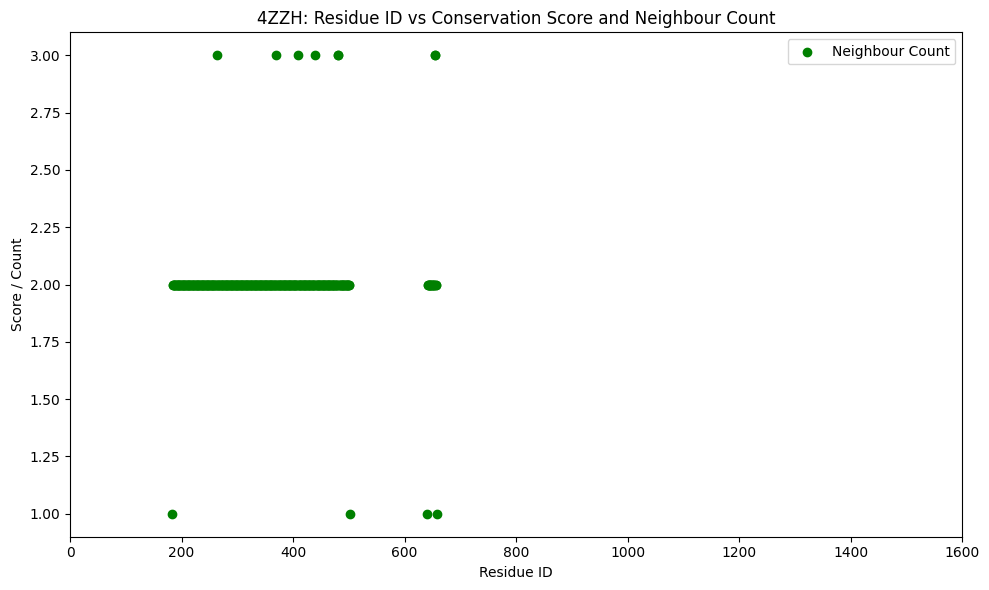

Summary for 4IF6 chain A saved successfully at conservation_scores/4IF6_consurf_summary.txt.
Summary for 4ZZH chain A saved successfully at conservation_scores/4ZZH_consurf_summary.txt.
Summary for 4IG9 chain A saved successfully at conservation_scores/4IG9_consurf_summary.txt.
Summary for 4I5I chain A saved successfully at conservation_scores/4I5I_consurf_summary.txt.
Summary for 4KXQ chain A saved successfully at conservation_scores/4KXQ_consurf_summary.txt.
Summary for 4I5I saved successfully.
Summary for 4IF6 saved successfully.
Summary for 4IG9 saved successfully.
Summary for 4KXQ saved successfully.
Summary for 4ZZH saved successfully.


In [51]:
ref_seq = './pdb/AF-Q96EB6-F1-model_v4.pdb'
ref_seq = pdb_to_n_neighbour_vector(ref_seq, angstrom = 4)

for pdb_file in pdb_file_path:
        
        completed = pdb_to_n_neighbour_vector(pdb_file, angstrom = 4)
        updated_ref_seq = merge_to_ref_seq(ref_seq, completed)

[{'chain_id': 'A', 'residue_name': 'MET', 'residue_id': 1, 'neighbour_count': 1}, {'chain_id': 'A', 'residue_name': 'ALA', 'residue_id': 2, 'neighbour_count': 2}, {'chain_id': 'A', 'residue_name': 'ASP', 'residue_id': 3, 'neighbour_count': 2}, {'chain_id': 'A', 'residue_name': 'GLU', 'residue_id': 4, 'neighbour_count': 2}, {'chain_id': 'A', 'residue_name': 'ALA', 'residue_id': 5, 'neighbour_count': 2}, {'chain_id': 'A', 'residue_name': 'ALA', 'residue_id': 6, 'neighbour_count': 2}, {'chain_id': 'A', 'residue_name': 'LEU', 'residue_id': 7, 'neighbour_count': 2}, {'chain_id': 'A', 'residue_name': 'ALA', 'residue_id': 8, 'neighbour_count': 2}, {'chain_id': 'A', 'residue_name': 'LEU', 'residue_id': 9, 'neighbour_count': 2}, {'chain_id': 'A', 'residue_name': 'GLN', 'residue_id': 10, 'neighbour_count': 2}, {'chain_id': 'A', 'residue_name': 'PRO', 'residue_id': 11, 'neighbour_count': 2}, {'chain_id': 'A', 'residue_name': 'GLY', 'residue_id': 12, 'neighbour_count': 2}, {'chain_id': 'A', 'resid

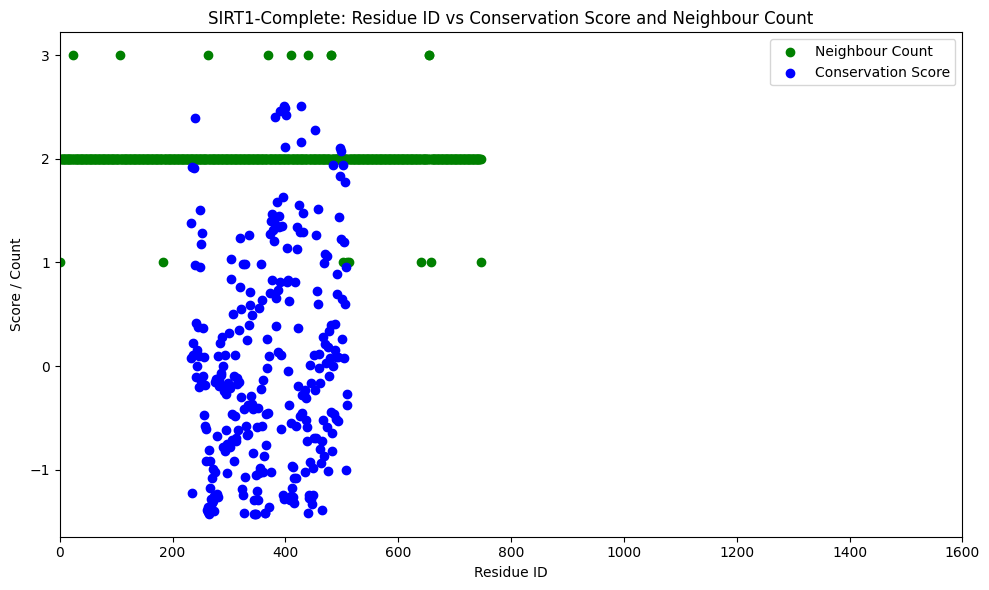

In [52]:
print(updated_ref_seq)
plot_and_calculate_correlation(updated_ref_seq, title='SIRT1-Complete')